# Field Capacity Finder from the soil moisture

## From the soil moisture data
***
### Data description
- data is being collected from the F70 field.
- soil moisture is in unit of %, **not cleaned**
- this script includes cleaning function
- this script designed to be used in daily basis.
- from the soil moisture monitoring website
- example data is 'Calc_def_test.csv'

- [soil moisture data](https://things.iot.ag.purdue.edu:8080/dashboard/dc56c5a0-ee3e-11ec-b72b-5dd76ca52a2b?publicId=a914a590-ecae-11ec-b72b-5dd76ca52a2b) input data for the script will be downloaded directly
> - soil moisture data is from Purdue AgIT server that collects the field data through LoRaWan network
> - the data should be downloaded from the 'Summary Data Table' tab
> 
- [weather data] input data for the script will be downloaded directly
> - weather data is from Purdue Mesonet server and using ACRE station data
>

# About the 'readraw_data' function
## About
***
### Job in the script
this function enable to read and parse the raw data downloaded from the Mesonet

In [202]:
# -*- coding: utf-8 -*-
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime as dt
import statistics as stats
import os


today = dt.date.today()
# today = datetime(2009, 7, 6, 0, 0)
strtoday = today.strftime("%Y%m%d")
print ('Today is :: ',today)



def readraw_data(destination, filename, foutname, st_date, ed_date):
    
    # open the file
    raw_data = pd.read_csv(filename,delimiter=';', parse_dates=['Timestamp'],
                          dtype={'data_soil_moisture1':np.float64,
                                 'data_soil_moisture2':np.float64,
                                 'data_soil_moisture3':np.float64,
                                 'data_soil_moisture4':np.float64},
                          na_values=['Invalid data']
                          )
    raw_columns = raw_data.columns.tolist()
    # raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'])
    # drop the temperature data from the list
    for i in range(len(raw_columns)):
        if 'tem' in raw_columns[i] or 'dev' in raw_columns[i]:
            raw_data = raw_data.drop(columns=raw_columns[i])
            
    raw_data.set_index(['Timestamp'])
    print(raw_data.info())
    
    # change the name of the Entity Name column
    raw_data['Entity Name'] = raw_data['Entity Name'].str.replace('ABE-DRAGINO-GROPOINT-CHERKHAUER-ACRE-','')
    stationlist = sorted(raw_data['Entity Name'].unique())
        
    
    # after checking the null values, filter the data
    clean_df = pd.DataFrame(columns = ['Station','Layer1', 'Layer2', 'Layer3', 'Layer4'])
    for station in stationlist:
        # clean the data according to the cleaning procedure
        sample_df = station_data_clean(destination, raw_data, station)
        
        clean_df = pd.concat([clean_df,sample_df])
        
    clean_df.to_csv(destination+foutname,index=True)
    
    # convert headers only with numbers
    raw_columns = raw_data.columns.tolist()
    
    # group the dataframe and turn them into another dataframe with 'Entity Name' as columns.
    # this step should be done by layer.
    

    return raw_data, raw_columns, clean_df, stationlist, raw_columns

Today is ::  2024-03-12


In [203]:
def station_data_clean(destination, raw_data, station):
    global start_date, end_date
    '''
    This is cleaning for station data

    Parameters
    ----------
    raw_data : dataframe
        dataframe of the raw_data, 'raw_data' in this script
    station : string
        this is number of station. 4 digit number filled with zero from left

    Returns
    -------
    sample_df : dataframe
        this cleaned data after process

    '''
    sample_df = raw_data[raw_data['Entity Name']==station]
    sample_df = sample_df.drop(['Entity Name'], axis=1)
    sample_df = sample_df.set_index('Timestamp')
    sample_df = sample_df.set_axis(['Layer1', 'Layer2', 'Layer3', 'Layer4'], axis=1)
    
    # clean the data by time of interest
    # datetime range should start by 18:00 // end by 6:00 for better analysis for everyday
    start_date = dt.datetime(st_date[0], st_date[1], st_date[2], 0, 0, 0)
    end_date = dt.datetime(ed_date[0], ed_date[1], ed_date[2], 6, 0, 0)
    sample_df = sample_df[(sample_df.index > start_date) & (sample_df.index < end_date)]
    
    # according to the number of the data length,
    # if it is more than 1, the dataframe will be made
    # if it is 0, below process will be skipped
    totnum = len(sample_df)
    if totnum > 0:    
        print ('\n\n')
        txt = ' raw_data info for station '+station+' '
        print(txt.center(60,'='),end='\n')
        
        # if value is null value from beginning
        print(' NaN values info '.center(60,':'))
        na_df = sample_df[sample_df.isna().any(axis=1)]
        sample_df = sample_df.dropna()
        print('NaN values are ::',len(na_df),'out of',totnum,'\nerror rate:',round(len(na_df)/totnum*100,2),'%',end='\n\n')
        
        # if value is out of range
        sample_df[(sample_df>=100.0) | (sample_df<=0.0)] = np.nan
        outrange_df = sample_df[sample_df.isna().any(axis=1)]
        sample_df = sample_df.dropna()
        print('Out of range values are ::',len(outrange_df),'out of',totnum,'\nerror rate:',round(len(outrange_df)/totnum*100,2),'%',end='\n\n')
        
        print(' Data Describe '.center(60,':'),end='\n\n')
        print(sample_df.dtypes, end='\n\n')
        print(sample_df.describe())
        
        # resampling in 30 min frequency
        sample_df = sample_df.resample('30min').mean()
        
        # make boxplot per layer
        boxplot = sample_df.boxplot(column=['Layer1', 'Layer2', 'Layer3'],figsize=(8,4), ylabel='Soil Moisture (%)')
        plt.title(int(station))
        plt.savefig(destination+'station_data_'+station+'.png',dpi=600)
        plt.show()
        
        # add station code back
        sample_df['Station'] = int(station)
    
        print('='*60)
        
    else:
        txt = station+' '
        print(txt.center(60,'='),end='\n\n')
    '''
    # save station dataframe as csv file == turned off for cal_deficit
    try:
        sample_df.to_csv(destination+'station_data/'+station+'_cleaned.csv',sep=',')
        print('Transmitter data exported.')
    except:
        print('Transmitter data export failed.')
    '''
    
    return sample_df

# About the 'rainfinder' function
## About
***
### Job in the script
this function find the big rain based on the soil moisture data
at the very bottom of the implementation block, you can find input values that you need for this function

In [204]:
def rainfinder(data, station, header, threshold_moist, raintimestep):
    """
    

    Parameters
    ----------
    data : dataframe
        organized dataframe / index is 'Timestamp and Station'
    stationlist : list
        list of the stations
    header : list
        header of the data
    threshold_moist : int
        threshold of soil moisture difference to decide it was huge rain event or not
        
    Returns
    -------
    data_dur_all : list of dataframe
        this is dataframes with time range of interest
        dataframe order is accordance with order of station list (stationlist)

    """
    # TODO: remove stationlist for the final version
    text = station +' :: '+target+'  Rainfinder'
    print (text.center(60,':'))

    data_dur = data[data['Station']==int(station)]
    data_dur = data_dur.dropna()
    
        
    # make a rolling window column from interpolation
    # data_dur[target] = data_dur[target].interpolate()
    print (station,'|','LEN =', len(data_dur))
    
    # find differene between each time step
    temp = data_dur[target].diff()
    filtered_temp = temp.to_frame(name=target).query('{target} > @threshold_moist'.format(target = target))
    
    # find biggest difference within 3 hours (6 timesteps) == bump
    data_dur['min_'+target] = data_dur[target].rolling(window=raintimestep).min()
    data_dur['max_'+target] = data_dur[target].rolling(window=raintimestep).max()
    data_dur['gap_'+target] = data_dur['max_'+target] - data_dur['min_'+target]
    filtered_temp = data_dur.query('gap_{target} > @threshold_moist'.format(target = target))
    #print (filtered_temp)

    # organizing the date of bump
    bumplist = filtered_temp.index.to_list()        
    for i in range(len(bumplist)):
        # make a list of date with the bump in the form of [year, month, day]
        bumplist[i] = [bumplist[i].year, bumplist[i].month, bumplist[i].day]
    # remove duplicates in bumplist
    bumplist2 = list(set(map(tuple, bumplist)))
    # sort the list and convert tuples into list
    bumplist2 = sorted(bumplist2)
    for i in range(len(bumplist2)):
        bumplist2[i] = list(bumplist2[i])

    print ('Searched ', len(bumplist2), 'days with bump events')
    print (bumplist2)

    return bumplist2

# About the 'FCfinder' function
## About
***
### Job in the script
this function find the field capacity right after the rainevent.
once the big rain event is found, this function will find the first consistent soil moisture tendency and consider it as field capacity.

In [205]:
def FCfinder(data, station, header, start_date, search_days, search_range, search_slope, threshold_hour):
    global searched, precip_search1, precip_search2, precip_delta, precip_max
    """
    

    Parameters
    ----------
    data : dataframe
        organized dataframe / index is 'Timestamp and Station'
    stationlist : list
        list of the stations
    header : list
        header of the data
    start_date : list[year, month, day]
        start date of the data search
    search_days : int
        searching days for field capacity
    search_range : int
        searching range (hours) for moving field capacity
    threshold_hour : int
        threshold hours that remains flat soil moisture behavior to confirm it is fc point

    Returns
    -------
    data_dur_all : list of dataframe
        this is dataframes with time range of interest
        dataframe order is accordance with order of station list (stationlist)

    """
    # print ('Station',station, 'Date',start_date)
    # important == rl means rolling window. if you don't want, remove it.
    search_target = 'rl_'+target

    data_dur_all = []

    #data.plot(x = data.index,  y = target, data = data[data['Station']==station])

    data_dur = data[data['Station']==int(station)]
    
        
    # make a rolling window column from interpolation
    data_dur[target] = data_dur[target].interpolate()
    # print (data_dur[target])
    data_dur['rl_'+target] = data_dur[target].rolling(window=3).mean()
    

    '''
    From here, we need to find out point where soil moisture value is consistent for 2 hours (threshold_hour)
    And consistent variation for this hour is < 1% (search_slope)
    Searching range will be +- 4hrs from midnight (search_range)
    '''
    # set the database only for the search_target
    target_data = data_dur[search_target]
    
    # find 00:00 hour of everyday within TOI (7 days)
    dayrange = search_days
    
    # this list is for the searched fc dates
    searched_list = []
    
    # searching field capacity (daily)
    for days in range(1,dayrange+1):
        # Going to find the field capacity after given days from the start_date
        st_datetime = dt.datetime(start_date[0], start_date[1], start_date[2], 6, 0, 0)

        # stamp2 is 4 hours before the midnight of the stamp1
        # stamp3 is 4 hours after the midnight of the stamp2
        # add 'days' to search every daily step
        stamp1 = st_datetime + dt.timedelta(days=days)
        stamp1 = stamp1.replace(hour=0, minute=0, second=0)
        # print(stamp1)
        
        # step 1. select the time range of interest
        # once you find the time, you will search there is constant soil moisture behavior or not
        # set the searching time
        stamp2 = stamp1 - dt.timedelta(hours=search_range)
        stamp3 = stamp1 + dt.timedelta(hours=search_range)
        # print(' SM ',stamp2, '--' ,stamp3)
        
        # step 2. set the searching range
        searched = target_data[(target_data.index > stamp2) & (target_data.index < stamp3)]
        # searched = data_search
            
        try:
            # print('STD::',round(stats.stdev(searched),2), 'MEAN::',round(stats.mean(searched),2))
            
            # if standard deviation does not exceeds 'search_slope',
            # this will be regarded as constant moisture behavior
            if stats.stdev(searched) < search_slope:
                searched_list.append([stamp1, stats.mean(searched)])
                FC_searched = True
            else:
                # print(stamp2,'has no moving field capacity.', end='\n\n')
                FC_searched = False
        except:
            # print(station, stamp2, 'has no data.', end='\n\n')
            FC_searched = False
        
        if FC_searched == True:
            print ('Field Capacity is found for',str(start_date[0])+'-'+str(start_date[1])+'-'+str(start_date[2]),':',searched_list[0][0].strftime('%Y-%m-%d'),round(searched_list[0][1],3))

        
            # list of searched field capacity
            searched_dates = [i[0] for i in searched_list]
            searched_values = [i[1] for i in searched_list]
            
            # if field capacity is found, draw graph
            if len(searched_dates) > 0:
                # draw overlaying graph for the soil moisture and field capacity
                # soil moisture is blue line and field capacity is red dot            
                # data_dur = data_dur.reset_index()
                df_subset = data_dur[(data_dur.index < stamp1+dt.timedelta(days=1)) & (data_dur.index > st_datetime)]
                print(df_subset)

                fig, ax = plt.subplots(figsize=(12, 5))
                # ax = data_dur.plot(y=target, label = 'Observed values', figsize=(15,5))
                ax = plt.plot(df_subset.index, df_subset[target], label = 'Observed values')

                # ax.set_xlim(stamp2, stamp3)
                plt.scatter(x=searched_dates, y=searched_values, label = 'Moving FC points', marker='s', c='r', s=100)
                plt.legend()
                plt.gcf().autofmt_xdate()
                plt.xlabel('Date')
                plt.ylabel('Soil Moisture (%)')
                plt.title('Field Capacity for '+str(station)+' after '+st_datetime.strftime('%Y-%m-%d'))

                # save graph for the soil moisture and field capacity                   
                plt.savefig(os.getcwd()+'/'+str(station)+'_'+stamp1.strftime('%Y-%m-%d')+'.png',dpi=600)
                plt.show()
                print('Graph is saved.')
            
            # save field capacity records in csv form
            data_dur_all.append(data_dur)
            
            
            # save field capacity records in csv form
            with  open(os.getcwd()+'/'+'fc_record.csv', 'a+') as f:
                for item in searched_list:
                    f.write(str(station)+','+item[0].strftime('%Y-%m-%d')+','+str(round(item[1],2))+'\n')
            
            break
    
    return data_dur_all

# Below is implementation Block

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134346 entries, 0 to 134345
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Timestamp            134346 non-null  datetime64[ns]
 1   Entity Name          134346 non-null  object        
 2   data_soil_moisture1  130675 non-null  float64       
 3   data_soil_moisture2  130675 non-null  float64       
 4   data_soil_moisture3  130675 non-null  float64       
 5   data_soil_moisture4  130675 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 6.1+ MB
None



============== raw_data info for station 0111 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 46 out of 10866 
error rate: 0.42 %

Out of range values are :: 2262 out of 10866 
error rate: 20.82 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer

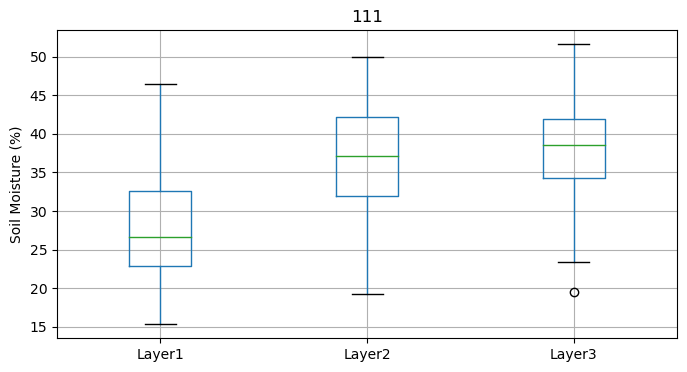




============== raw_data info for station 0112 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 350 out of 12680 
error rate: 2.76 %

Out of range values are :: 2891 out of 12680 
error rate: 22.8 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  9439.000000  9439.000000  9439.000000  9439.000000
mean     34.266257    37.680464    39.150450    38.080528
std       5.933412     5.874834     4.550641     5.727906
min      14.000000    14.500000    16.000000    15.500000
25%      30.200000    31.700000    36.400000    35.200000
50%      33.800000    39.900000    39.600000    37.300000
75%      38.200000    42.200000    41.700000    40.300000
max      47.400000    50.700000    52.000000    54.900000


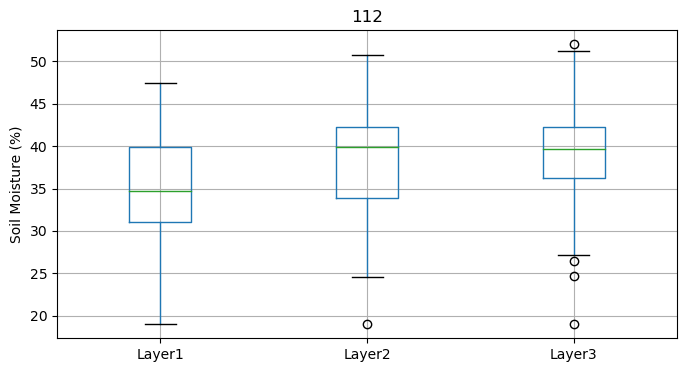




============== raw_data info for station 0113 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 629 out of 11988 
error rate: 5.25 %

Out of range values are :: 3461 out of 11988 
error rate: 28.87 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  7898.000000  7898.000000  7898.000000  7898.000000
mean     23.660433    35.166662    34.406711    33.372905
std       8.382626     7.839859     4.031715     5.381765
min       8.700000    14.500000    16.000000    16.500000
25%      16.100000    35.900000    32.900000    30.900000
50%      24.500000    37.200000    36.100000    31.800000
75%      29.200000    38.700000    36.500000    32.400000
max      48.500000    49.400000    45.800000    47.900000


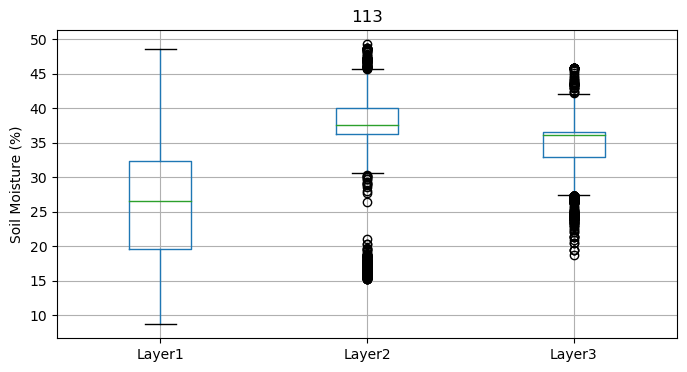




============== raw_data info for station 0114 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 395 out of 11121 
error rate: 3.55 %

Out of range values are :: 1775 out of 11121 
error rate: 15.96 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  8951.000000  8951.000000  8951.000000  8951.000000
mean     28.143548    36.221562    32.142085    33.089834
std       6.137461     5.766305     5.354067     6.618490
min      13.500000    14.000000    15.000000    15.000000
25%      23.050000    33.100000    28.300000    29.900000
50%      27.000000    36.400000    32.200000    31.900000
75%      31.800000    39.200000    34.700000    34.700000
max      51.000000    55.400000    54.000000    54.800000


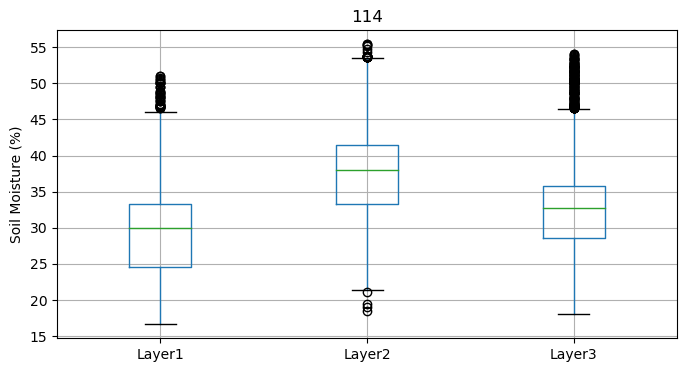




============== raw_data info for station 0115 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 156 out of 1350 
error rate: 11.56 %

Out of range values are :: 0 out of 1350 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2      Layer3       Layer4
count  1194.000000  1194.000000  1194.00000  1194.000000
mean     28.412228    34.787186    39.43995    47.880067
std       4.637366     3.571355     1.93903     1.313527
min      21.500000    28.100000    34.60000    44.900000
25%      23.900000    32.000000    39.12500    47.600000
50%      27.900000    35.700000    40.00000    47.900000
75%      32.600000    37.400000    40.30000    48.600000
max      42.600000    44.400000    45.20000    51.300000


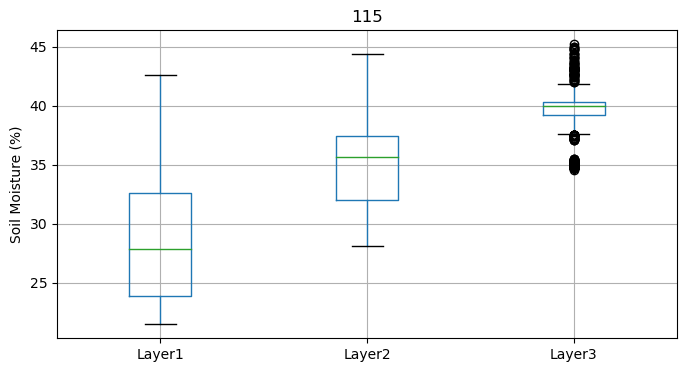




============== raw_data info for station 0116 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 98 out of 7926 
error rate: 1.24 %

Out of range values are :: 3026 out of 7926 
error rate: 38.18 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  4802.000000  4802.000000  4802.000000  4802.000000
mean     36.172387    42.655227    46.002770    48.317264
std       8.533128     9.653798     9.269674     9.762863
min      11.500000    14.000000    15.000000    16.500000
25%      31.000000    35.700000    44.500000    48.300000
50%      35.400000    47.500000    47.700000    49.200000
75%      40.900000    49.600000    49.500000    49.900000
max      64.200000    62.900000    59.300000    62.300000


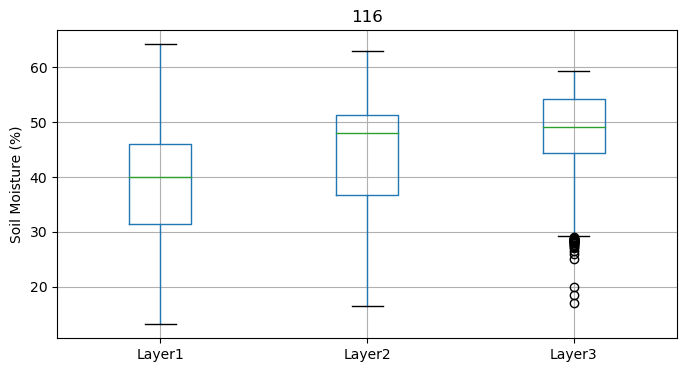




============== raw_data info for station 0117 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 150 out of 150 
error rate: 100.0 %

Out of range values are :: 0 out of 150 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

       Layer1  Layer2  Layer3  Layer4
count     0.0     0.0     0.0     0.0
mean      NaN     NaN     NaN     NaN
std       NaN     NaN     NaN     NaN
min       NaN     NaN     NaN     NaN
25%       NaN     NaN     NaN     NaN
50%       NaN     NaN     NaN     NaN
75%       NaN     NaN     NaN     NaN
max       NaN     NaN     NaN     NaN


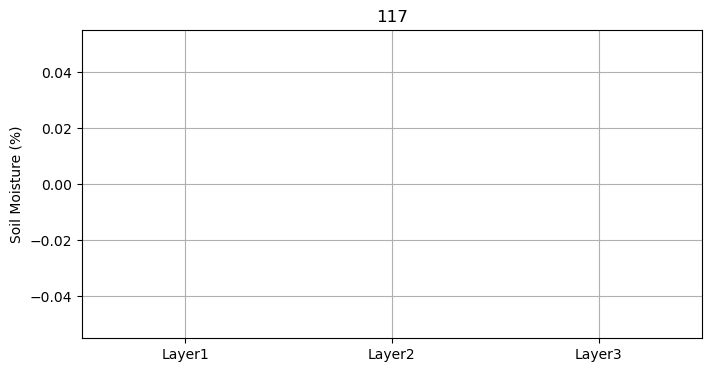




============== raw_data info for station 0118 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 551 out of 12998 
error rate: 4.24 %

Out of range values are :: 3113 out of 12998 
error rate: 23.95 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  9334.000000  9334.000000  9334.000000  9334.000000
mean     20.997150    33.114667    33.803203    37.408228
std       5.158414     6.058246     4.508284     5.786959
min      10.500000    12.500000    14.000000    16.000000
25%      16.600000    29.300000    32.300000    34.500000
50%      20.000000    33.400000    34.100000    36.400000
75%      24.300000    38.400000    35.400000    41.100000
max      49.200000    51.700000    51.100000    53.800000


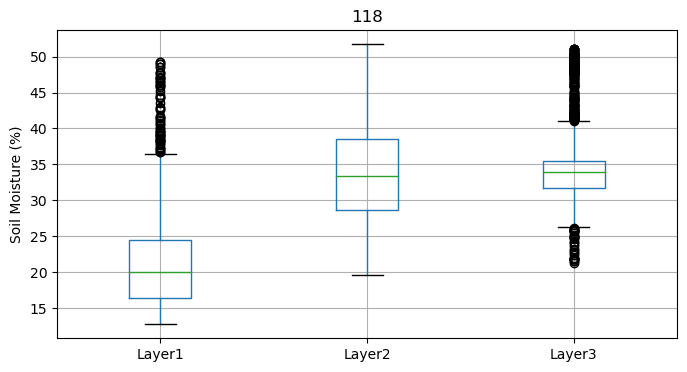




============== raw_data info for station 0554 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 0 out of 3696 
error rate: 0.0 %

Out of range values are :: 0 out of 3696 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  3696.000000  3696.000000  3696.000000  3696.000000
mean     36.586174    42.654978    45.679924    46.362365
std       4.814616     4.201911     2.218052     0.604063
min      29.500000    35.600000    40.700000    44.800000
25%      33.200000    39.100000    43.900000    45.900000
50%      34.700000    42.000000    45.500000    46.300000
75%      39.200000    45.800000    47.100000    46.800000
max      48.700000    52.300000    51.000000    48.000000


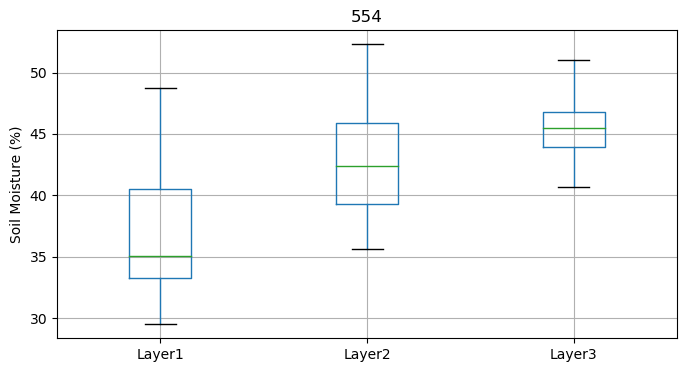




============== raw_data info for station 0555 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 0 out of 4065 
error rate: 0.0 %

Out of range values are :: 0 out of 4065 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  4065.000000  4065.000000  4065.000000  4065.000000
mean     42.212571    46.269865    46.439385    48.626175
std       4.089530     3.604725     4.448682     4.794904
min      32.500000    38.500000    37.500000    41.300000
25%      40.000000    44.000000    43.500000    44.300000
50%      41.400000    45.900000    47.100000    48.400000
75%      44.200000    48.300000    49.400000    51.300000
max      63.500000    59.500000    60.200000    62.500000


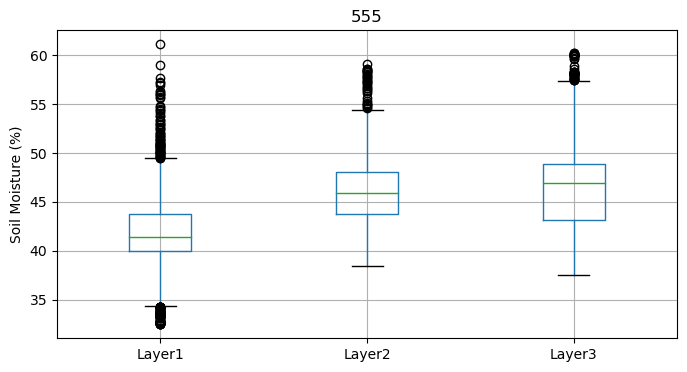




============== raw_data info for station 0556 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 0 out of 3913 
error rate: 0.0 %

Out of range values are :: 2 out of 3913 
error rate: 0.05 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  3911.000000  3911.000000  3911.000000  3911.000000
mean     18.523268    23.199719    29.118486    40.054257
std       5.625640     6.932995     7.687963     6.361625
min       9.700000    15.000000    19.700000    31.700000
25%      13.800000    17.400000    22.900000    33.800000
50%      17.600000    20.800000    25.500000    38.600000
75%      22.000000    28.000000    34.200000    44.700000
max      46.900000    50.800000    52.700000    53.200000


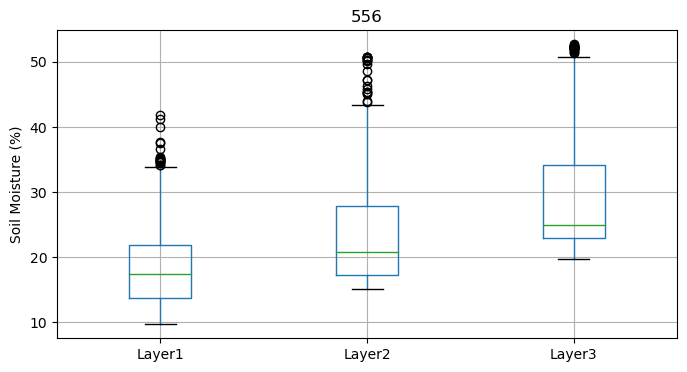




============== raw_data info for station 0557 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 0 out of 4255 
error rate: 0.0 %

Out of range values are :: 0 out of 4255 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  4255.000000  4255.000000  4255.000000  4255.000000
mean     27.917086    31.926063    36.078261    37.584277
std       6.011207     4.876275     3.817731     3.450792
min      12.700000    20.200000    21.300000    22.700000
25%      23.600000    29.000000    34.000000    35.300000
50%      26.400000    32.900000    35.800000    37.900000
75%      31.500000    35.200000    37.800000    39.800000
max      44.900000    44.600000    46.400000    45.100000


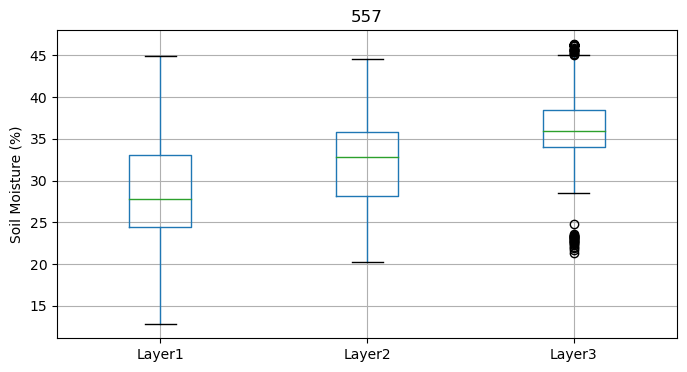




============== raw_data info for station 0558 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 0 out of 4146 
error rate: 0.0 %

Out of range values are :: 2 out of 4146 
error rate: 0.05 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  4144.000000  4144.000000  4144.000000  4144.000000
mean     31.945391    38.104995    37.310256    32.519184
std       7.293102     5.540374     7.043540     9.540792
min       2.600000    21.000000    17.200000    15.000000
25%      28.900000    33.700000    34.400000    21.000000
50%      33.400000    38.800000    34.600000    33.000000
75%      37.300000    43.200000    46.400000    43.200000
max      42.200000    46.600000    48.800000    46.600000


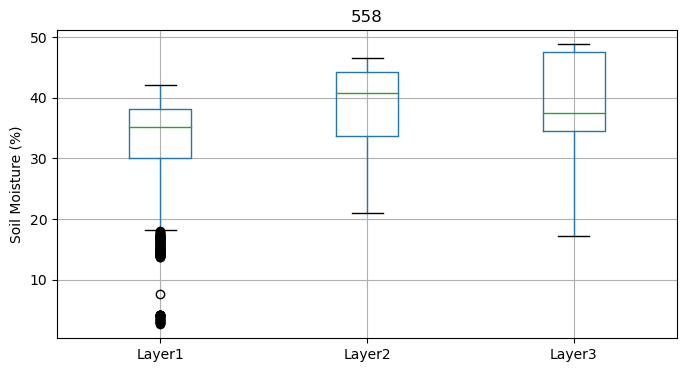




============== raw_data info for station 0629 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 0 out of 389 
error rate: 0.0 %

Out of range values are :: 0 out of 389 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

           Layer1      Layer2      Layer3      Layer4
count  389.000000  389.000000  389.000000  389.000000
mean    12.894859   43.233419   46.069152   45.196915
std      3.036407    1.658519    0.602807    0.687173
min      9.200000   40.200000   45.000000   44.000000
25%     10.400000   41.600000   45.400000   44.500000
50%     12.300000   43.600000   46.500000   45.500000
75%     14.500000   44.700000   46.600000   45.800000
max     27.700000   46.600000   46.700000   45.900000


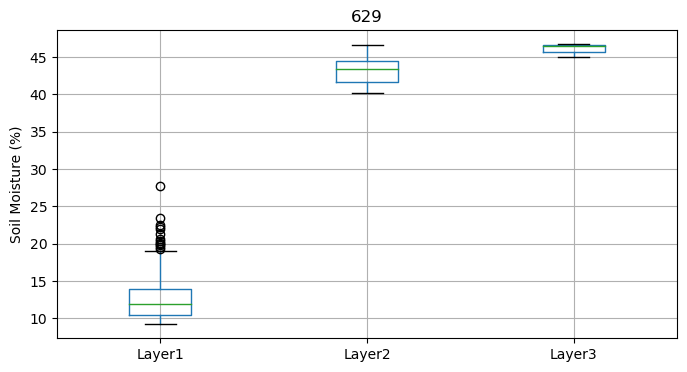




============== raw_data info for station 0630 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 0 out of 523 
error rate: 0.0 %

Out of range values are :: 0 out of 523 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

           Layer1      Layer2      Layer3      Layer4
count  523.000000  523.000000  523.000000  523.000000
mean    22.639771   37.820459   29.865966   26.026386
std      1.411415    1.136617    0.571001    0.231337
min     20.600000   36.000000   28.800000   25.500000
25%     21.200000   36.700000   29.300000   25.900000
50%     22.500000   37.800000   30.000000   26.100000
75%     23.900000   38.900000   30.400000   26.200000
max     25.000000   39.600000   30.700000   26.400000


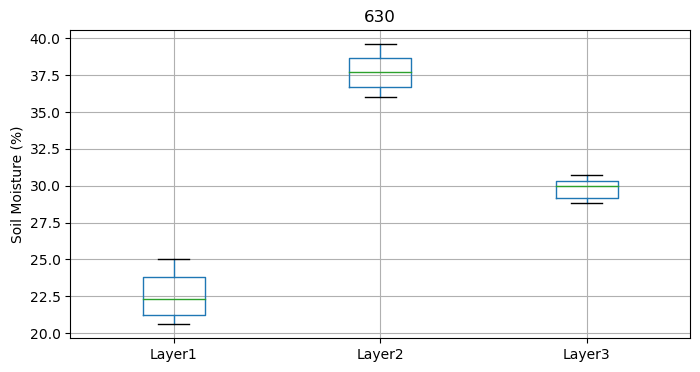




============== raw_data info for station 2492 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 0 out of 4323 
error rate: 0.0 %

Out of range values are :: 1443 out of 4323 
error rate: 33.38 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  2880.000000  2880.000000  2880.000000  2880.000000
mean     18.997292    38.153090    33.673958    28.869514
std       3.121822     2.018935     4.092228     2.607031
min      14.500000    31.800000    27.700000    22.100000
25%      17.100000    36.500000    29.400000    25.800000
50%      18.400000    37.300000    33.600000    29.600000
75%      20.200000    40.000000    37.900000    31.400000
max      37.500000    45.100000    39.900000    32.600000


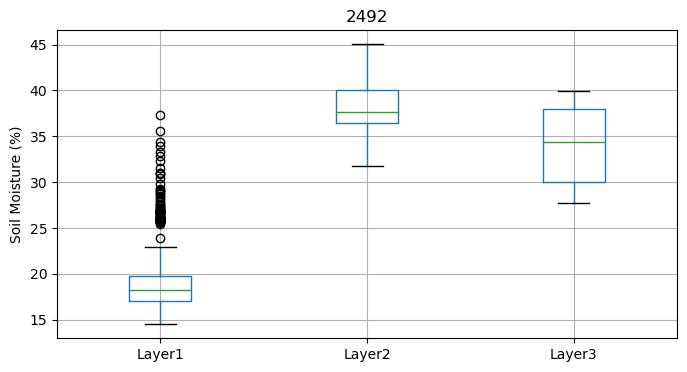

Station List :: ['0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0554', '0555', '0556', '0557', '0558', '0629', '0630', '2492']



=======================0111 :: Layer2=======================
:::::::::::::::::0111 :: Layer2  Rainfinder:::::::::::::::::
0111 | LEN = 3887
Searched  5 days with bump events
[[2023, 7, 8], [2023, 7, 15], [2023, 7, 28], [2023, 8, 5], [2023, 8, 6]]
Field Capacity is found for 2023-7-8 : 2023-07-17 42.58
                    Station     Layer1     Layer2     Layer3  Layer4  \
2023-07-08 06:30:00     111  46.066667  49.100000  51.366667    54.3   
2023-07-08 07:00:00     111  46.100000  49.400000  51.400000    54.3   
2023-07-08 07:30:00     111  46.200000  49.533333  51.500000    54.4   
2023-07-08 08:00:00     111  46.166667  49.600000  51.500000    54.4   
2023-07-08 08:30:00     111  44.366667  49.600000  51.500000    54.4   
...                     ...        ...        ...        ...     ...   
2023-07-17 21:30:00     111        NaN  41.55

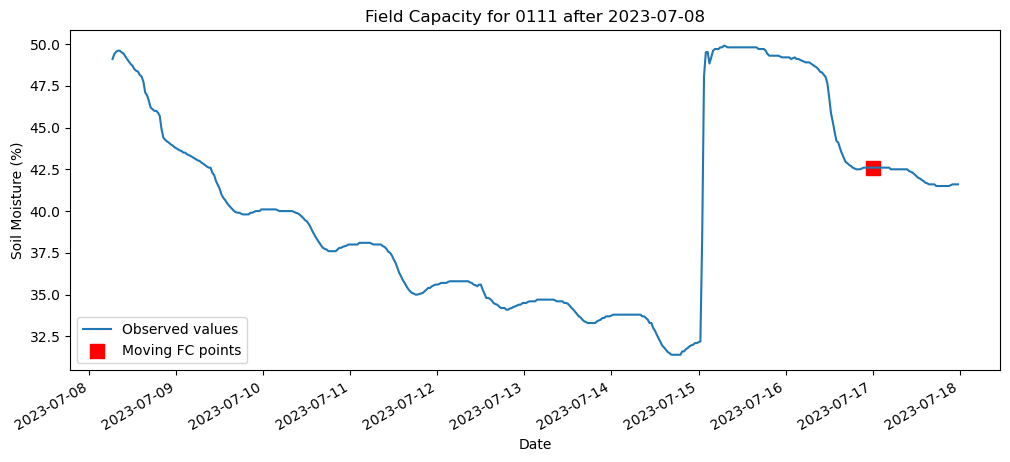

Graph is saved.
Field Capacity is found for 2023-7-15 : 2023-07-17 42.58
                    Station     Layer1     Layer2  Layer3     Layer4  \
2023-07-15 06:30:00     111  46.300000  49.800000    51.4  54.500000   
2023-07-15 07:00:00     111  46.400000  49.900000    51.5  54.533333   
2023-07-15 07:30:00     111  46.400000  49.866667    51.5  54.600000   
2023-07-15 08:00:00     111  46.400000  49.800000    51.5  54.600000   
2023-07-15 08:30:00     111  46.466667  49.800000    51.5  54.600000   
...                     ...        ...        ...     ...        ...   
2023-07-17 21:30:00     111        NaN  41.550000     NaN        NaN   
2023-07-17 22:00:00     111  34.000000  41.600000    43.2  44.200000   
2023-07-17 22:30:00     111  34.000000  41.600000    43.2  44.200000   
2023-07-17 23:00:00     111  34.000000  41.600000    43.2  44.200000   
2023-07-17 23:30:00     111        NaN  41.600000     NaN        NaN   

                     rl_Layer2  
2023-07-15 06:30:00  49.76666

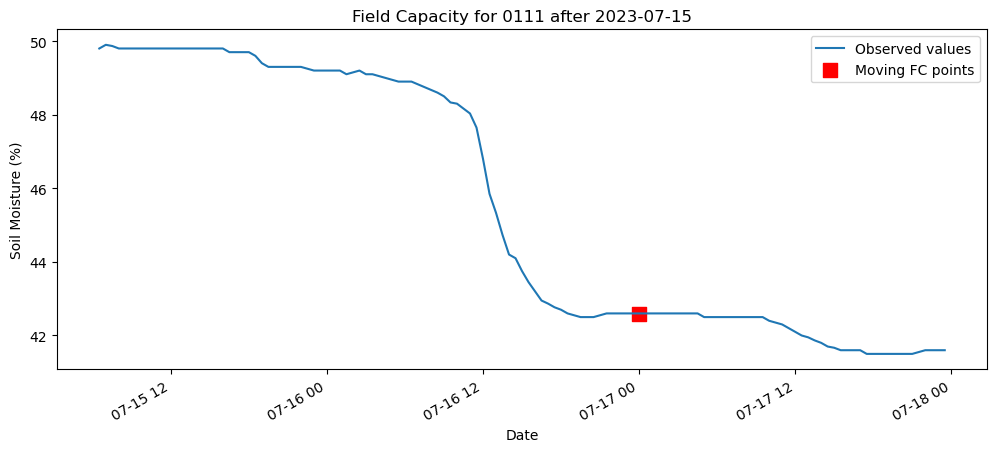

Graph is saved.
Field Capacity is found for 2023-7-28 : 2023-07-31 39.495
                    Station  Layer1  Layer2  Layer3  Layer4  rl_Layer2
2023-07-28 06:30:00     111    24.9   32.20    33.0    30.2  32.200000
2023-07-28 07:00:00     111    28.1   35.30    34.4    30.3  33.233333
2023-07-28 07:30:00     111     NaN   39.55     NaN     NaN  35.683333
2023-07-28 08:00:00     111    42.0   43.80    38.0    32.6  39.550000
2023-07-28 08:30:00     111    42.4   47.40    45.0    41.5  43.583333
...                     ...     ...     ...     ...     ...        ...
2023-07-31 21:30:00     111    29.7   37.30    38.0    35.6  37.283333
2023-07-31 22:00:00     111    29.7   37.30    38.0    35.6  37.300000
2023-07-31 22:30:00     111     NaN   37.35     NaN     NaN  37.316667
2023-07-31 23:00:00     111    29.7   37.40    38.0    35.7  37.350000
2023-07-31 23:30:00     111    29.7   37.40    38.0    35.7  37.383333

[179 rows x 6 columns]


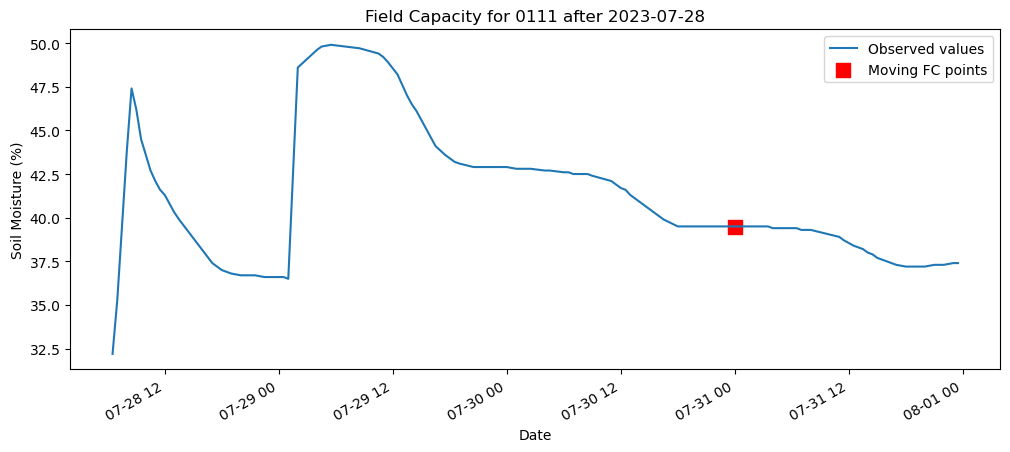

Graph is saved.
Field Capacity is found for 2023-8-5 : 2023-08-08 48.624
                    Station  Layer1  Layer2  Layer3  Layer4  rl_Layer2
2023-08-05 06:30:00     111    26.0   32.20    32.4    30.5  32.211111
2023-08-05 07:00:00     111    26.0   32.20    32.4    30.5  32.200000
2023-08-05 07:30:00     111    26.0   32.20    32.4    30.6  32.200000
2023-08-05 08:00:00     111    25.9   32.20    32.4    30.6  32.200000
2023-08-05 08:30:00     111    25.9   32.20    32.4    30.6  32.200000
...                     ...     ...     ...     ...     ...        ...
2023-08-08 21:30:00     111    44.8   47.30    47.3    49.5  47.275000
2023-08-08 22:00:00     111    44.7   47.30    47.3    49.4  47.291667
2023-08-08 22:30:00     111    44.7   47.30    47.3    49.5  47.300000
2023-08-08 23:00:00     111     NaN   47.32     NaN     NaN  47.306667
2023-08-08 23:30:00     111     NaN   47.34     NaN     NaN  47.320000

[179 rows x 6 columns]


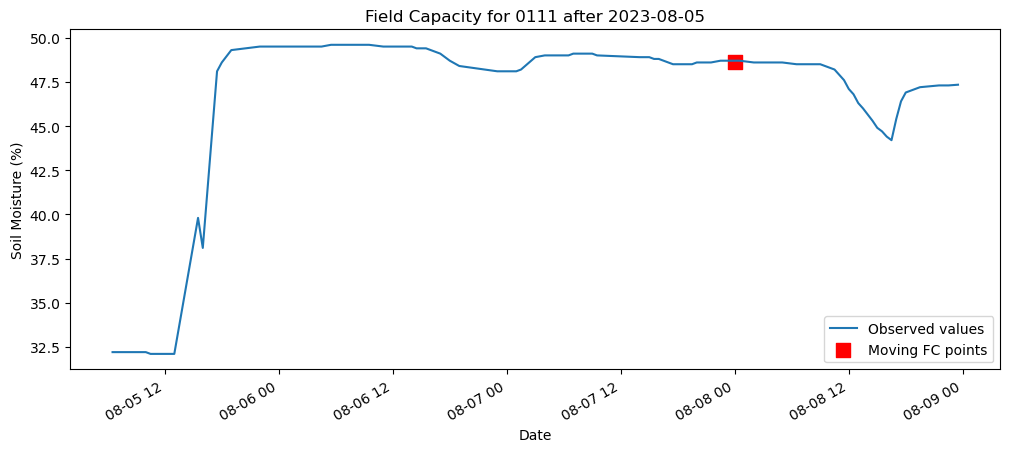

Graph is saved.
Field Capacity is found for 2023-8-6 : 2023-08-08 48.624
                    Station  Layer1  Layer2  Layer3  Layer4  rl_Layer2
2023-08-06 06:30:00     111    44.6   49.60    50.9    54.6  49.600000
2023-08-06 07:00:00     111    44.5   49.60    50.9    54.6  49.600000
2023-08-06 07:30:00     111    44.4   49.60    50.9    54.6  49.600000
2023-08-06 08:00:00     111     NaN   49.60     NaN     NaN  49.600000
2023-08-06 08:30:00     111     NaN   49.60     NaN     NaN  49.600000
...                     ...     ...     ...     ...     ...        ...
2023-08-08 21:30:00     111    44.8   47.30    47.3    49.5  47.275000
2023-08-08 22:00:00     111    44.7   47.30    47.3    49.4  47.291667
2023-08-08 22:30:00     111    44.7   47.30    47.3    49.5  47.300000
2023-08-08 23:00:00     111     NaN   47.32     NaN     NaN  47.306667
2023-08-08 23:30:00     111     NaN   47.34     NaN     NaN  47.320000

[131 rows x 6 columns]


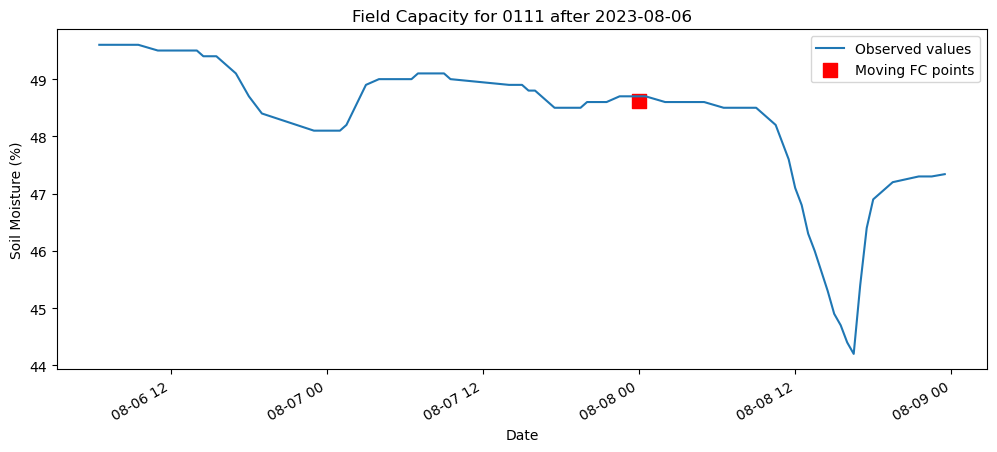

Graph is saved.



=======================0112 :: Layer2=======================
:::::::::::::::::0112 :: Layer2  Rainfinder:::::::::::::::::
0112 | LEN = 4320
Searched  6 days with bump events
[[2023, 5, 12], [2023, 5, 16], [2023, 5, 17], [2023, 6, 12], [2023, 8, 5], [2023, 8, 6]]
Field Capacity is found for 2023-6-12 : 2023-06-22 29.39
                    Station     Layer1     Layer2     Layer3     Layer4  \
2023-06-12 06:30:00     112        NaN  29.408189        NaN        NaN   
2023-06-12 07:00:00     112        NaN  29.385512        NaN        NaN   
2023-06-12 07:30:00     112        NaN  29.362835        NaN        NaN   
2023-06-12 08:00:00     112        NaN  29.340157        NaN        NaN   
2023-06-12 08:30:00     112        NaN  29.317480        NaN        NaN   
...                     ...        ...        ...        ...        ...   
2023-06-22 21:30:00     112  25.933333  29.000000  32.366667  31.633333   
2023-06-22 22:00:00     112  25.900000  29.000000  32.400000 

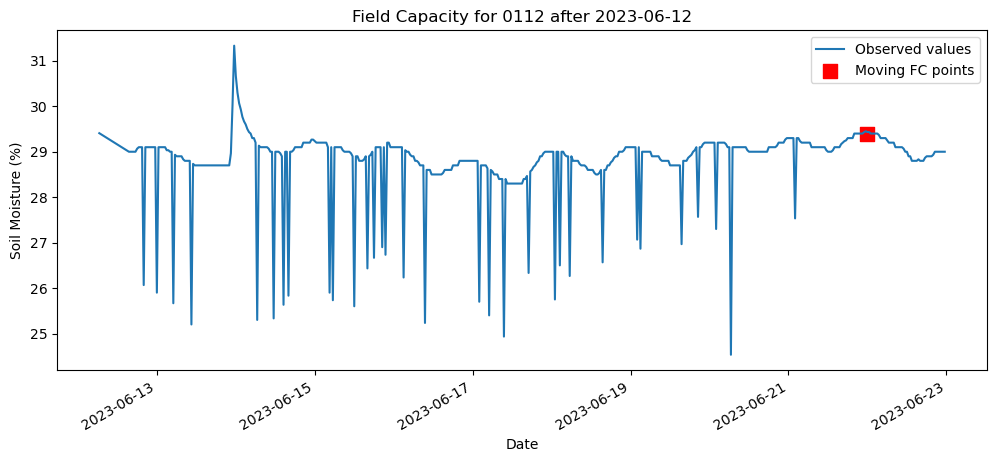

Graph is saved.
Field Capacity is found for 2023-8-5 : 2023-08-15 43.038
                    Station  Layer1  Layer2  Layer3  Layer4  rl_Layer2
2023-08-05 06:30:00     112    31.3    31.8    33.6    31.6       31.8
2023-08-05 07:00:00     112    31.3    31.8    33.7    31.6       31.8
2023-08-05 07:30:00     112    31.3    31.8    33.6    31.6       31.8
2023-08-05 08:00:00     112    31.2    31.8    33.6    31.6       31.8
2023-08-05 08:30:00     112    31.2    31.8    33.6    31.6       31.8
...                     ...     ...     ...     ...     ...        ...
2023-08-15 21:30:00     112    41.7    42.5    44.3    41.5       42.5
2023-08-15 22:00:00     112    41.6    42.5    44.3    41.6       42.5
2023-08-15 22:30:00     112    41.6    42.5    44.3    41.6       42.5
2023-08-15 23:00:00     112    41.6    42.5    44.4    41.6       42.5
2023-08-15 23:30:00     112     NaN    42.5     NaN     NaN       42.5

[515 rows x 6 columns]


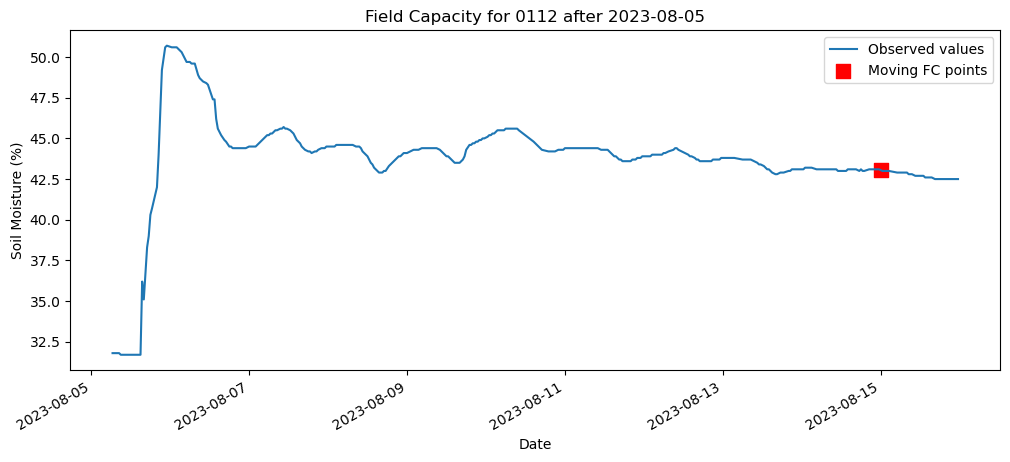

Graph is saved.
Field Capacity is found for 2023-8-6 : 2023-08-15 43.038
                    Station  Layer1  Layer2  Layer3  Layer4  rl_Layer2
2023-08-06 06:30:00     112    46.0   49.60    51.2    54.3  49.666667
2023-08-06 07:00:00     112     NaN   49.60     NaN     NaN  49.633333
2023-08-06 07:30:00     112    46.0   49.60    51.2    54.3  49.600000
2023-08-06 08:00:00     112     NaN   49.25     NaN     NaN  49.483333
2023-08-06 08:30:00     112    45.9   48.90    51.2    54.3  49.250000
...                     ...     ...     ...     ...     ...        ...
2023-08-15 21:30:00     112    41.7   42.50    44.3    41.5  42.500000
2023-08-15 22:00:00     112    41.6   42.50    44.3    41.6  42.500000
2023-08-15 22:30:00     112    41.6   42.50    44.3    41.6  42.500000
2023-08-15 23:00:00     112    41.6   42.50    44.4    41.6  42.500000
2023-08-15 23:30:00     112     NaN   42.50     NaN     NaN  42.500000

[467 rows x 6 columns]


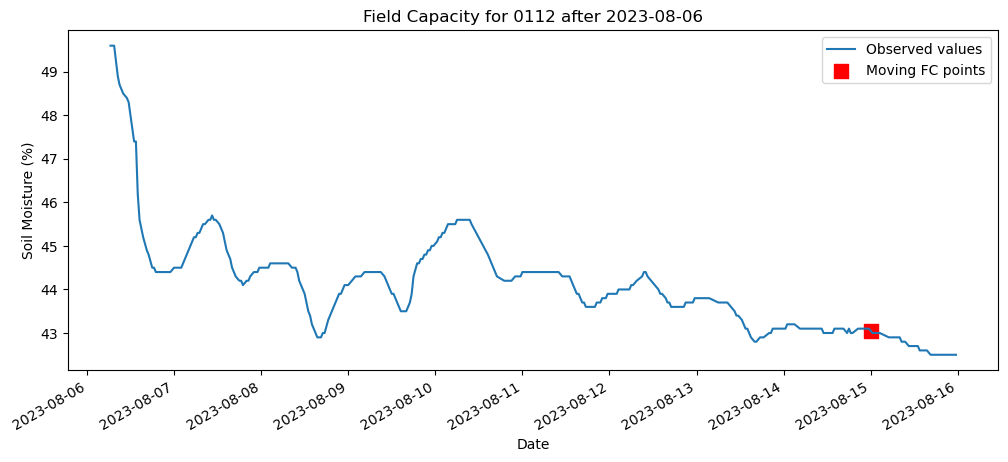

Graph is saved.



=======================0113 :: Layer2=======================
:::::::::::::::::0113 :: Layer2  Rainfinder:::::::::::::::::
0113 | LEN = 3780
Searched  2 days with bump events
[[2023, 6, 15], [2023, 6, 17]]



=======================0114 :: Layer2=======================
:::::::::::::::::0114 :: Layer2  Rainfinder:::::::::::::::::
0114 | LEN = 3971
Searched  4 days with bump events
[[2023, 5, 26], [2023, 7, 29], [2023, 8, 5], [2023, 8, 6]]
Field Capacity is found for 2023-5-26 : 2023-05-31 35.923
                    Station     Layer1     Layer2     Layer3     Layer4  \
2023-05-26 06:30:00     114  22.400000  35.900000  33.300000  31.500000   
2023-05-26 07:00:00     114  20.600000  29.766667  28.533333  27.166667   
2023-05-26 07:30:00     114  22.333333  35.800000  33.300000  31.500000   
2023-05-26 08:00:00     114  22.300000  35.766667  33.300000  31.500000   
2023-05-26 08:30:00     114  20.533333  29.466667  28.366667  27.000000   
...                     ...     

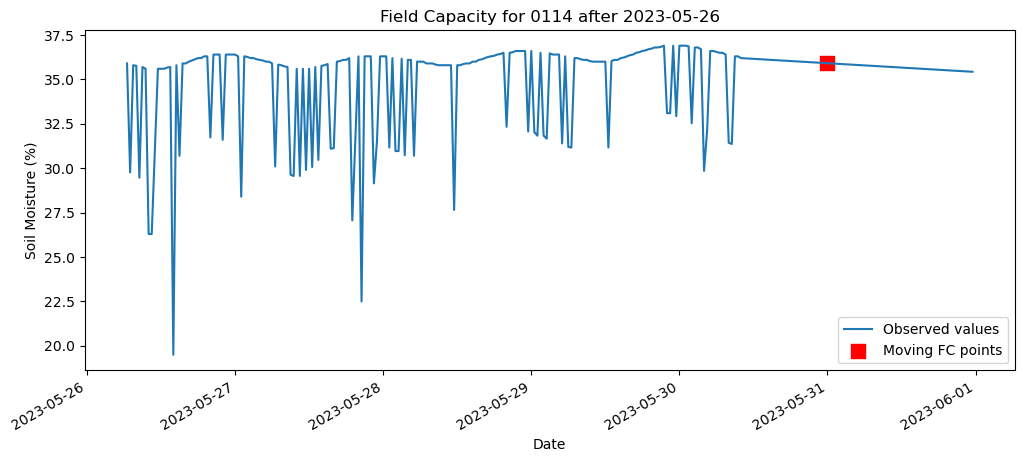

Graph is saved.
Field Capacity is found for 2023-7-29 : 2023-07-30 43.981
                    Station  Layer1     Layer2  Layer3  Layer4  rl_Layer2
2023-07-29 06:30:00     114    42.7  51.500000    53.3    50.7  52.466667
2023-07-29 07:00:00     114     NaN  51.000000     NaN     NaN  51.700000
2023-07-29 07:30:00     114    42.3  50.500000    53.3    50.7  51.000000
2023-07-29 08:00:00     114    42.2  50.200000    53.0    50.7  50.566667
2023-07-29 08:30:00     114     NaN  49.900000     NaN     NaN  50.200000
...                     ...     ...        ...     ...     ...        ...
2023-07-30 21:30:00     114    35.0  42.500000    35.6    36.2  42.466667
2023-07-30 22:00:00     114    35.0  42.500000    35.6    36.2  42.500000
2023-07-30 22:30:00     114     NaN  42.533333     NaN     NaN  42.511111
2023-07-30 23:00:00     114     NaN  42.566667     NaN     NaN  42.533333
2023-07-30 23:30:00     114    34.9  42.600000    35.7    36.2  42.566667

[83 rows x 6 columns]


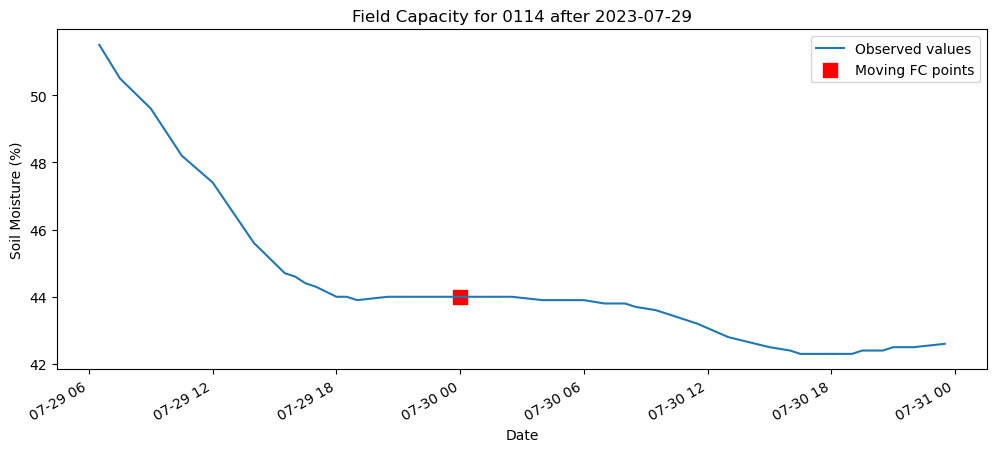

Graph is saved.
Field Capacity is found for 2023-8-5 : 2023-08-10 52.362
                    Station  Layer1     Layer2  Layer3  Layer4  rl_Layer2
2023-08-05 06:30:00     114     NaN  38.400000     NaN     NaN  38.433333
2023-08-05 07:00:00     114    29.7  38.400000    30.4    29.6  38.400000
2023-08-05 07:30:00     114     NaN  38.400000     NaN     NaN  38.400000
2023-08-05 08:00:00     114    29.6  38.400000    30.4    29.6  38.400000
2023-08-05 08:30:00     114    29.6  38.400000    30.4    29.6  38.400000
...                     ...     ...        ...     ...     ...        ...
2023-08-10 21:30:00     114     NaN  48.675000     NaN     NaN  48.650000
2023-08-10 22:00:00     114    41.3  48.700000    46.5    48.8  48.675000
2023-08-10 22:30:00     114     NaN  48.733333     NaN     NaN  48.702778
2023-08-10 23:00:00     114     NaN  48.766667     NaN     NaN  48.733333
2023-08-10 23:30:00     114    41.2  48.800000    46.5    48.8  48.766667

[275 rows x 6 columns]


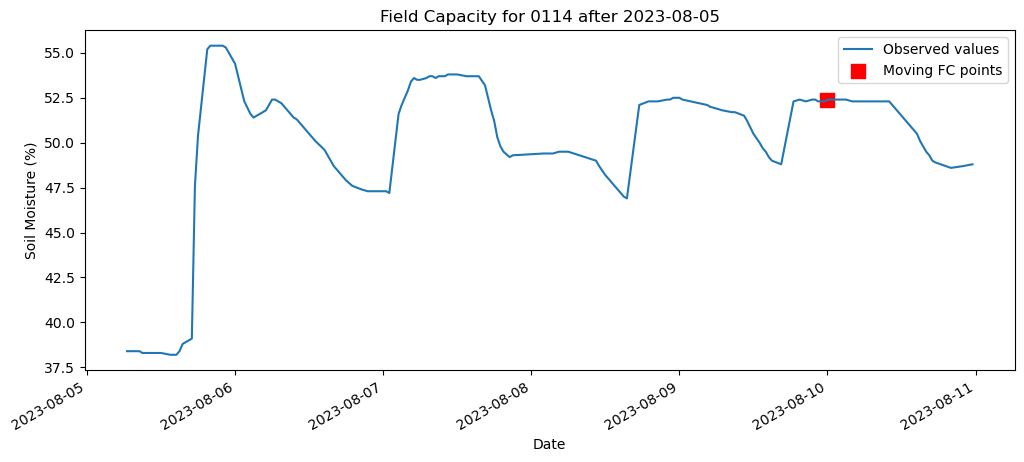

Graph is saved.
Field Capacity is found for 2023-8-6 : 2023-08-10 52.362
                    Station  Layer1     Layer2  Layer3  Layer4  rl_Layer2
2023-08-06 06:30:00     114    43.2  52.400000    51.2    50.7  52.300000
2023-08-06 07:00:00     114     NaN  52.300000     NaN     NaN  52.366667
2023-08-06 07:30:00     114    43.0  52.200000    51.1    50.7  52.300000
2023-08-06 08:00:00     114    43.0  52.000000    50.6    50.6  52.166667
2023-08-06 08:30:00     114    43.0  51.800000    50.5    50.6  52.000000
...                     ...     ...        ...     ...     ...        ...
2023-08-10 21:30:00     114     NaN  48.675000     NaN     NaN  48.650000
2023-08-10 22:00:00     114    41.3  48.700000    46.5    48.8  48.675000
2023-08-10 22:30:00     114     NaN  48.733333     NaN     NaN  48.702778
2023-08-10 23:00:00     114     NaN  48.766667     NaN     NaN  48.733333
2023-08-10 23:30:00     114    41.2  48.800000    46.5    48.8  48.766667

[227 rows x 6 columns]


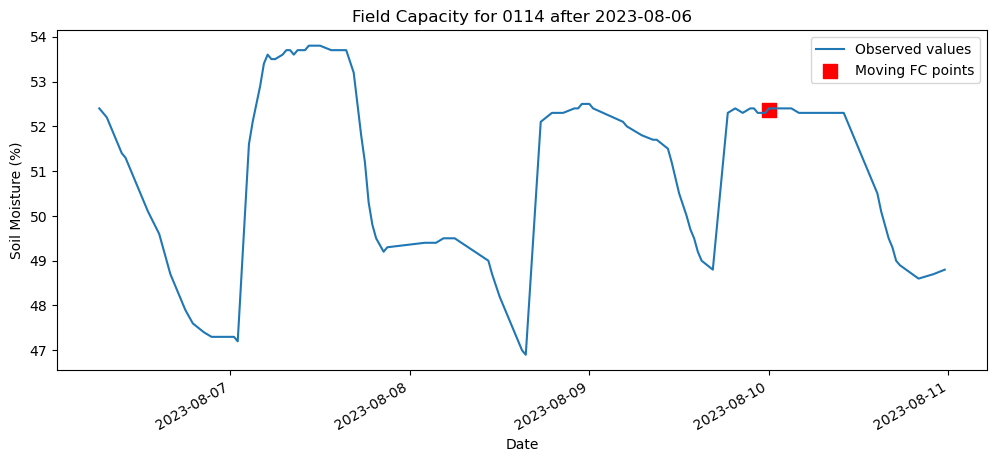

Graph is saved.



=======================0115 :: Layer2=======================
:::::::::::::::::0115 :: Layer2  Rainfinder:::::::::::::::::
0115 | LEN = 1193
Searched  0 days with bump events
[]



=======================0116 :: Layer2=======================
:::::::::::::::::0116 :: Layer2  Rainfinder:::::::::::::::::
0116 | LEN = 2457
Searched  15 days with bump events
[[2023, 5, 17], [2023, 5, 18], [2023, 5, 19], [2023, 5, 20], [2023, 5, 21], [2023, 5, 22], [2023, 5, 23], [2023, 5, 24], [2023, 5, 25], [2023, 5, 26], [2023, 5, 27], [2023, 5, 28], [2023, 5, 29], [2023, 5, 30], [2023, 6, 12]]
Field Capacity is found for 2023-6-12 : 2023-06-24 36.849
                    Station     Layer1     Layer2     Layer3  Layer4  \
2023-06-12 06:30:00     116        NaN  34.983438        NaN     NaN   
2023-06-12 07:00:00     116        NaN  34.960883        NaN     NaN   
2023-06-12 07:30:00     116        NaN  34.938328        NaN     NaN   
2023-06-12 08:00:00     116        NaN  34.915773     

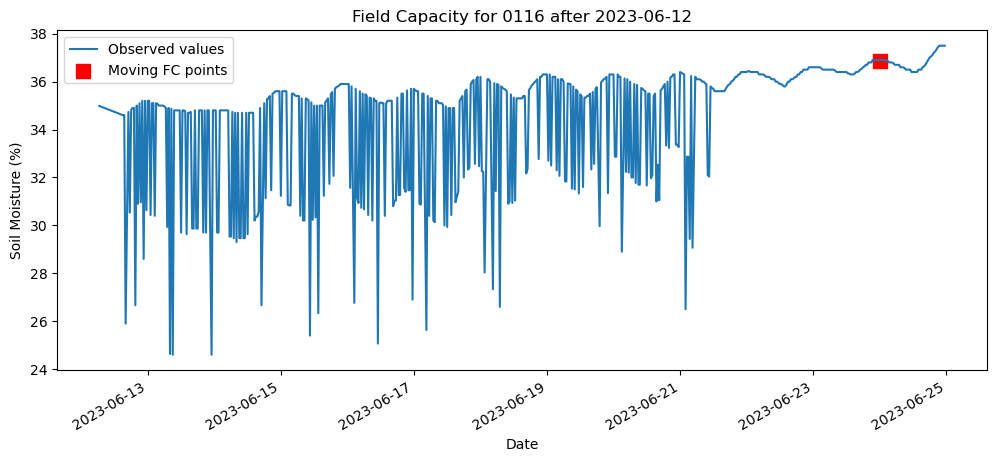

Graph is saved.



=======================0117 :: Layer2=======================
:::::::::::::::::0117 :: Layer2  Rainfinder:::::::::::::::::
0117 | LEN = 0
Searched  0 days with bump events
[]



=======================0118 :: Layer2=======================
:::::::::::::::::0118 :: Layer2  Rainfinder:::::::::::::::::
0118 | LEN = 4339
Searched  4 days with bump events
[[2023, 6, 25], [2023, 7, 28], [2023, 8, 5], [2023, 8, 6]]
Field Capacity is found for 2023-6-25 : 2023-07-01 33.353
                    Station     Layer1     Layer2     Layer3     Layer4  \
2023-06-25 06:30:00     118  31.500000  37.633333  40.233333  49.266667   
2023-06-25 07:00:00     118  26.066667  35.133333  38.600000  46.266667   
2023-06-25 07:30:00     118  24.450000  34.200000  37.750000  45.500000   
2023-06-25 08:00:00     118  23.200000  33.550000  37.050000  44.900000   
2023-06-25 08:30:00     118  22.833333  33.333333  36.666667  44.600000   
...                     ...        ...        ...        ...   

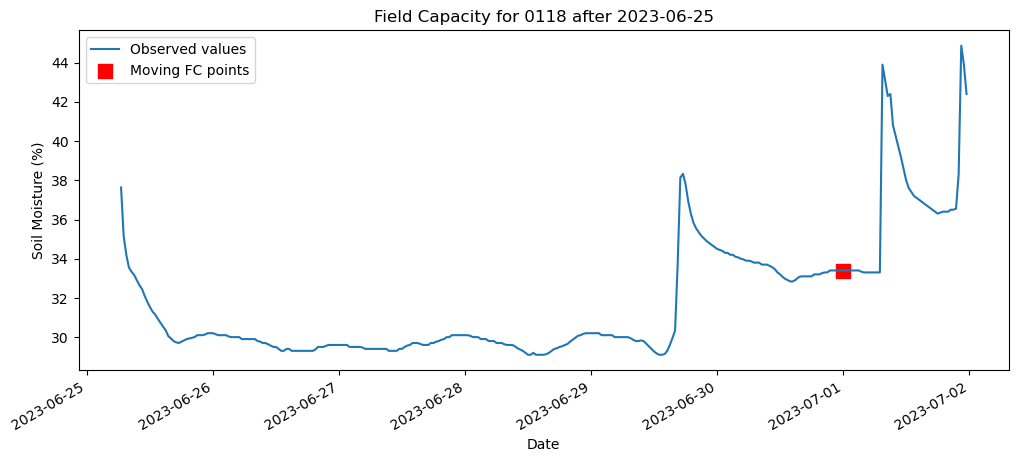

Graph is saved.
Field Capacity is found for 2023-7-28 : 2023-07-30 40.457
                    Station  Layer1  Layer2  Layer3  Layer4  rl_Layer2
2023-07-28 06:30:00     118    16.3    30.0    33.2    34.5  30.000000
2023-07-28 07:00:00     118    16.4    30.0    33.2    34.6  30.000000
2023-07-28 07:30:00     118    18.5    31.5    33.2    34.5  30.500000
2023-07-28 08:00:00     118    17.8    31.5    33.2    34.6  31.000000
2023-07-28 08:30:00     118    49.0    51.5    49.3    53.2  38.166667
...                     ...     ...     ...     ...     ...        ...
2023-07-30 21:30:00     118    20.5    37.8    38.3    40.2  37.733333
2023-07-30 22:00:00     118    20.4    37.8    38.3    40.1  37.766667
2023-07-30 22:30:00     118    20.4    37.8    38.3    40.1  37.800000
2023-07-30 23:00:00     118    20.4    37.9    38.3    40.0  37.833333
2023-07-30 23:30:00     118    20.3    37.9    38.3    40.0  37.866667

[131 rows x 6 columns]


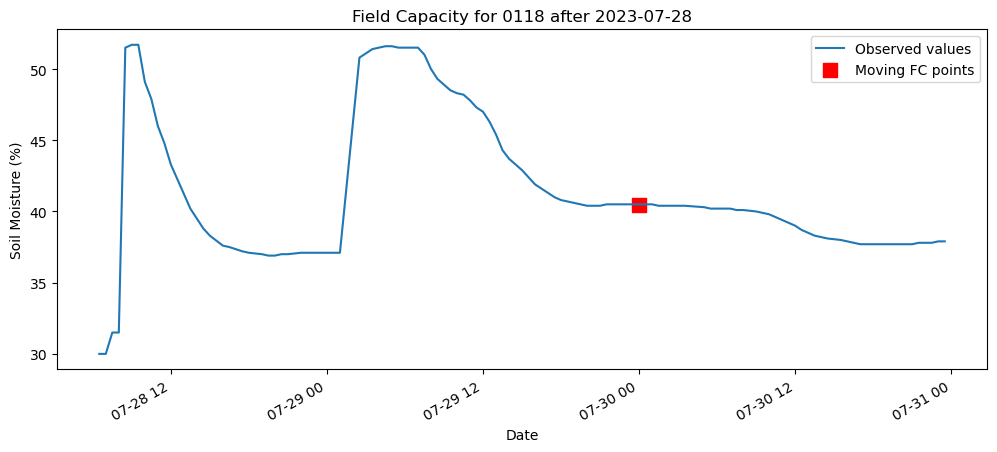

Graph is saved.
Field Capacity is found for 2023-8-5 : 2023-08-10 48.918
                    Station  Layer1  Layer2  Layer3  Layer4  rl_Layer2
2023-08-05 06:30:00     118    12.9    24.6    30.2    34.3  24.600000
2023-08-05 07:00:00     118    12.9    24.6    30.2    34.3  24.600000
2023-08-05 07:30:00     118    12.8    24.6    30.2    34.3  24.600000
2023-08-05 08:00:00     118    12.8    24.6    30.2    34.3  24.600000
2023-08-05 08:30:00     118    12.8    24.5    30.2    34.3  24.566667
...                     ...     ...     ...     ...     ...        ...
2023-08-10 21:30:00     118    29.5    41.7    39.2    45.1  41.633333
2023-08-10 22:00:00     118    29.5    41.7    39.2    45.0  41.666667
2023-08-10 22:30:00     118    29.4    41.8    39.2    44.9  41.733333
2023-08-10 23:00:00     118    29.4    41.8    39.2    44.8  41.766667
2023-08-10 23:30:00     118    29.3    41.8    39.2    44.7  41.800000

[275 rows x 6 columns]


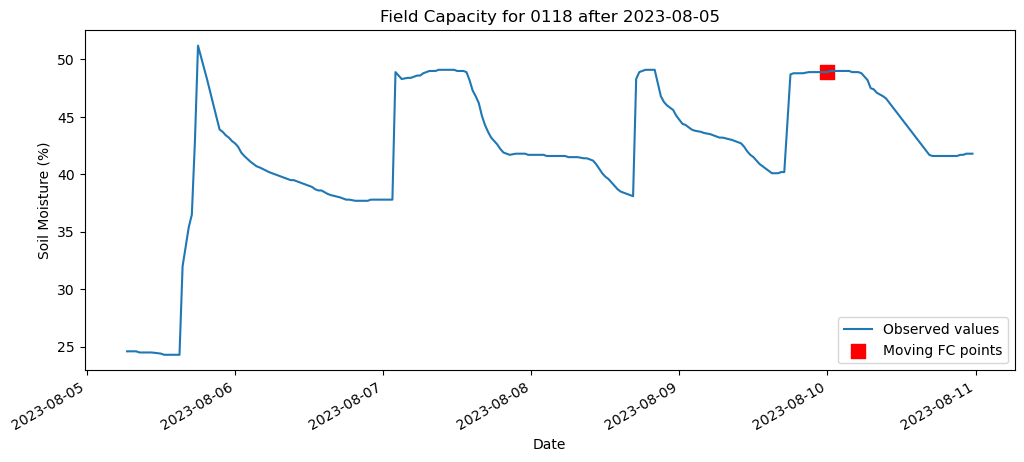

Graph is saved.
Field Capacity is found for 2023-8-6 : 2023-08-10 48.918
                    Station  Layer1  Layer2  Layer3  Layer4  rl_Layer2
2023-08-06 06:30:00     118    28.3    40.0    40.4    48.4  40.100000
2023-08-06 07:00:00     118     NaN    39.9     NaN     NaN  40.000000
2023-08-06 07:30:00     118    28.0    39.8    40.3    48.0  39.900000
2023-08-06 08:00:00     118    27.8    39.7    40.2    47.8  39.800000
2023-08-06 08:30:00     118    27.7    39.6    40.1    47.6  39.700000
...                     ...     ...     ...     ...     ...        ...
2023-08-10 21:30:00     118    29.5    41.7    39.2    45.1  41.633333
2023-08-10 22:00:00     118    29.5    41.7    39.2    45.0  41.666667
2023-08-10 22:30:00     118    29.4    41.8    39.2    44.9  41.733333
2023-08-10 23:00:00     118    29.4    41.8    39.2    44.8  41.766667
2023-08-10 23:30:00     118    29.3    41.8    39.2    44.7  41.800000

[227 rows x 6 columns]


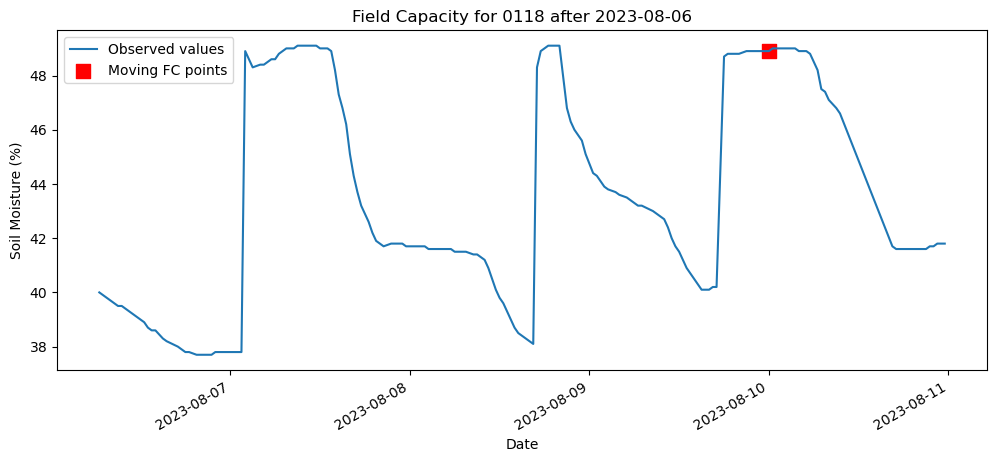

Graph is saved.



=======================0554 :: Layer2=======================
:::::::::::::::::0554 :: Layer2  Rainfinder:::::::::::::::::
0554 | LEN = 2273
Searched  0 days with bump events
[]



=======================0555 :: Layer2=======================
:::::::::::::::::0555 :: Layer2  Rainfinder:::::::::::::::::
0555 | LEN = 1564
Searched  0 days with bump events
[]



=======================0556 :: Layer2=======================
:::::::::::::::::0556 :: Layer2  Rainfinder:::::::::::::::::
0556 | LEN = 1513
Searched  4 days with bump events
[[2023, 7, 8], [2023, 7, 15], [2023, 7, 19], [2023, 7, 23]]
Field Capacity is found for 2023-7-8 : 2023-07-10 18.261
                    Station     Layer1     Layer2     Layer3     Layer4  \
2023-07-08 06:30:00     556  18.933333  18.833333  22.833333  33.200000   
2023-07-08 07:00:00     556  20.050000  21.500000  24.950000  33.300000   
2023-07-08 07:30:00     556  22.766667  26.866667  42.900000  50.800000   
2023-07-08 08:00:00     556  2

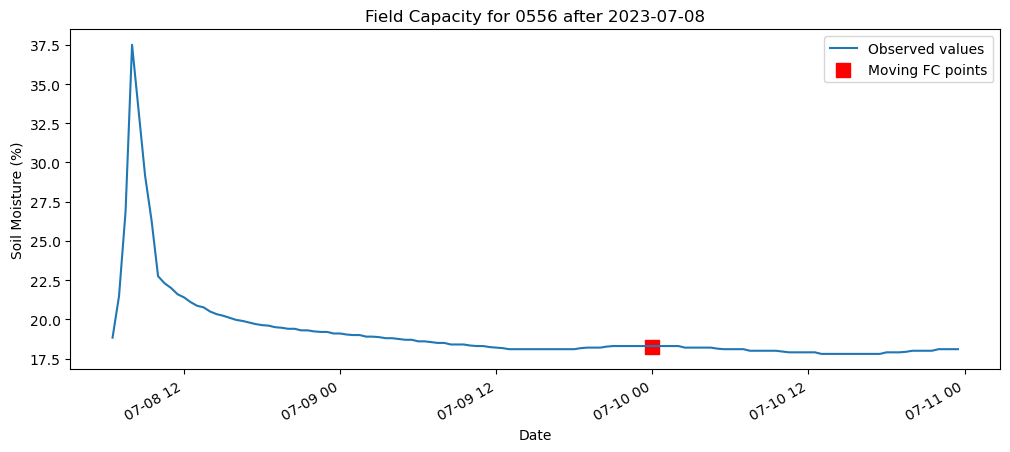

Graph is saved.
Field Capacity is found for 2023-7-15 : 2023-07-18 23.058
                    Station     Layer1     Layer2     Layer3     Layer4  \
2023-07-15 06:30:00     556  39.966667  50.566667  52.100000  52.800000   
2023-07-15 07:00:00     556  41.866667  50.700000  52.200000  52.866667   
2023-07-15 07:30:00     556  37.466667  50.700000  52.200000  52.900000   
2023-07-15 08:00:00     556  31.866667  50.700000  52.200000  52.966667   
2023-07-15 08:30:00     556  27.166667  50.766667  52.200000  53.000000   
...                     ...        ...        ...        ...        ...   
2023-07-18 21:30:00     556  18.500000  23.200000  20.733333  36.900000   
2023-07-18 22:00:00     556  18.466667  23.200000  20.800000  36.900000   
2023-07-18 22:30:00     556  18.400000  23.200000  20.800000  36.950000   
2023-07-18 23:00:00     556  18.400000  23.200000  20.800000  37.000000   
2023-07-18 23:30:00     556  18.400000  23.200000  20.800000  37.000000   

                     rl_L

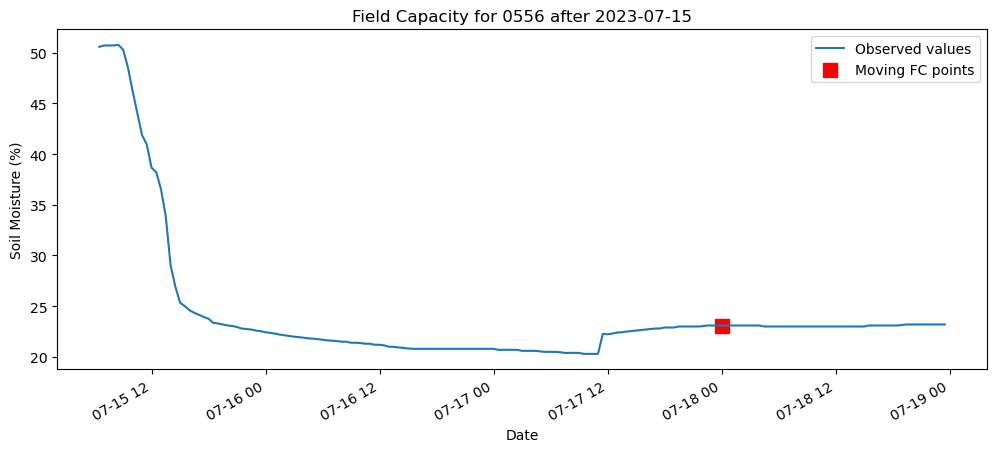

Graph is saved.
Field Capacity is found for 2023-7-19 : 2023-07-26 27.718
                    Station     Layer1     Layer2  Layer3  Layer4  rl_Layer2
2023-07-19 06:30:00     556  18.033333  22.900000    20.8    37.1  22.955556
2023-07-19 07:00:00     556  18.000000  22.900000    20.8    37.2  22.922222
2023-07-19 07:30:00     556  18.000000  22.900000    20.8    37.2  22.900000
2023-07-19 08:00:00     556  18.000000  22.900000    20.8    37.2  22.900000
2023-07-19 08:30:00     556  18.000000  22.866667    20.8    37.2  22.888889
...                     ...        ...        ...     ...     ...        ...
2023-07-26 21:30:00     556  21.900000  27.500000    33.2    44.3  27.511111
2023-07-26 22:00:00     556  21.900000  27.500000    33.2    44.3  27.500000
2023-07-26 22:30:00     556  21.900000  27.533333    33.2    44.3  27.511111
2023-07-26 23:00:00     556  21.900000  27.500000    33.2    44.3  27.511111
2023-07-26 23:30:00     556  21.900000  27.500000    33.2    44.3  27.511111

[

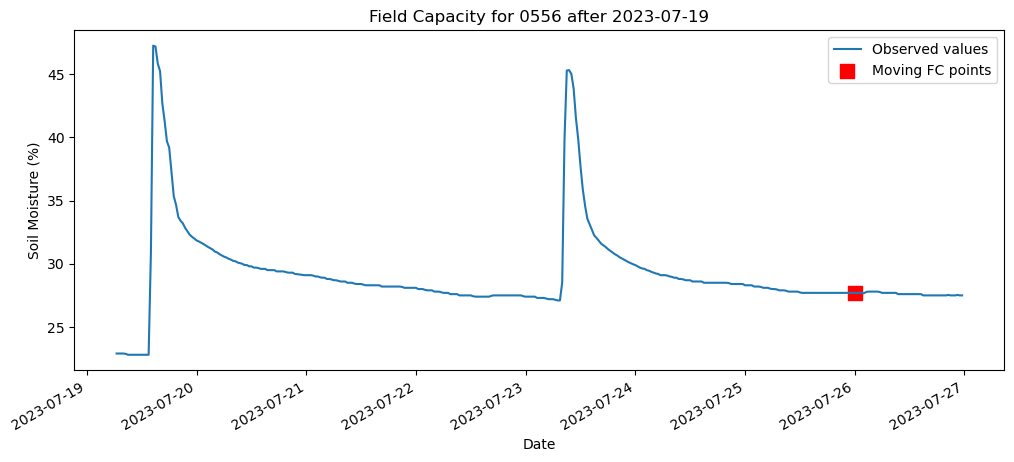

Graph is saved.
Field Capacity is found for 2023-7-23 : 2023-07-26 27.718
                    Station     Layer1     Layer2  Layer3     Layer4  \
2023-07-23 06:30:00     556  20.900000  27.150000    32.6  44.200000   
2023-07-23 07:00:00     556  20.900000  27.100000    32.6  44.200000   
2023-07-23 07:30:00     556  20.900000  27.100000    32.6  44.166667   
2023-07-23 08:00:00     556  24.566667  28.533333    33.1  44.200000   
2023-07-23 08:30:00     556  35.300000  39.833333    40.7  48.200000   
...                     ...        ...        ...     ...        ...   
2023-07-26 21:30:00     556  21.900000  27.500000    33.2  44.300000   
2023-07-26 22:00:00     556  21.900000  27.500000    33.2  44.300000   
2023-07-26 22:30:00     556  21.900000  27.533333    33.2  44.300000   
2023-07-26 23:00:00     556  21.900000  27.500000    33.2  44.300000   
2023-07-26 23:30:00     556  21.900000  27.500000    33.2  44.300000   

                     rl_Layer2  
2023-07-23 06:30:00  27.1833

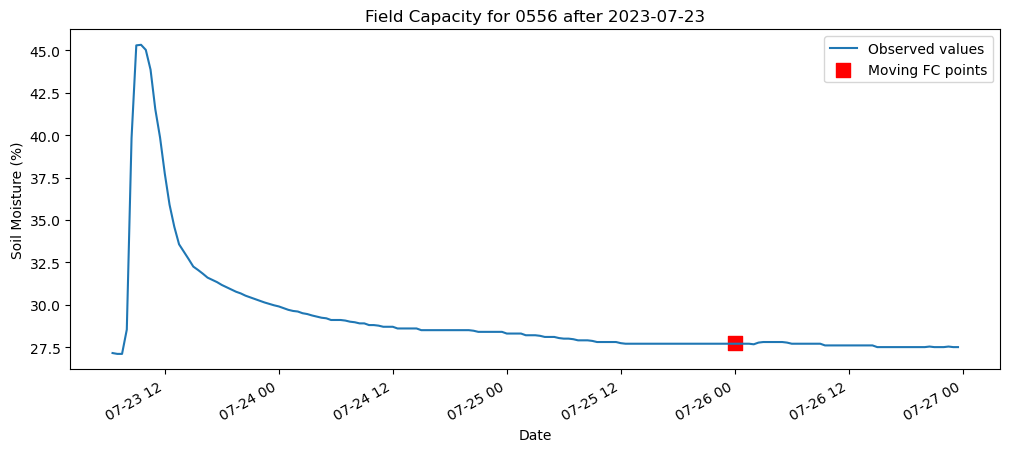

Graph is saved.



=======================0557 :: Layer2=======================
:::::::::::::::::0557 :: Layer2  Rainfinder:::::::::::::::::
0557 | LEN = 2514
Searched  4 days with bump events
[[2023, 7, 5], [2023, 7, 6], [2023, 7, 28], [2023, 8, 5]]
Field Capacity is found for 2023-7-5 : 2023-07-13 32.725
                    Station     Layer1  Layer2     Layer3     Layer4  \
2023-07-05 10:30:00     557  12.775000   21.05  21.375000  22.725000   
2023-07-05 11:00:00     557  12.900000   21.35  21.650000  23.000000   
2023-07-05 11:30:00     557  13.000000   21.55  21.950000  23.200000   
2023-07-05 12:00:00     557  13.100000   21.70  22.033333  23.333333   
2023-07-05 12:30:00     557  13.250000   21.85  22.250000  23.450000   
...                     ...        ...     ...        ...        ...   
2023-07-13 21:30:00     557  21.300000   31.80  34.000000  34.500000   
2023-07-13 22:00:00     557  21.266667   31.80  34.000000  34.466667   
2023-07-13 22:30:00     557  21.200000   31.

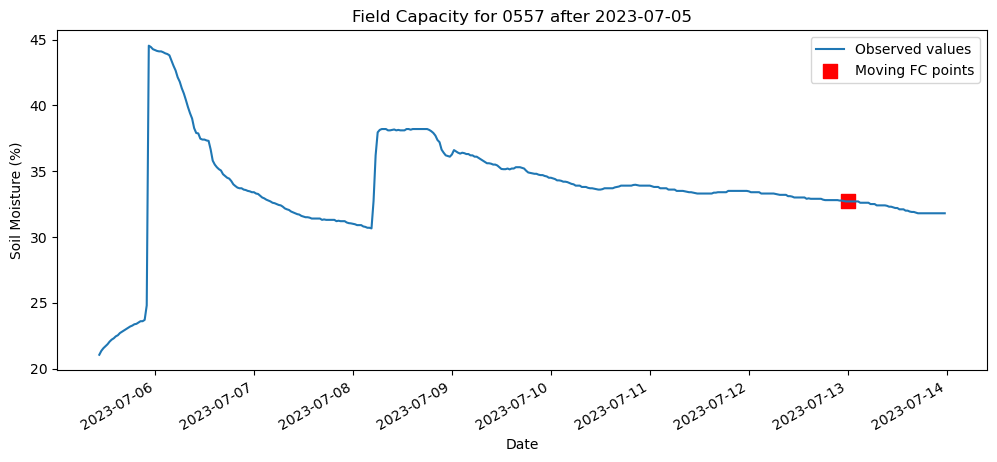

Graph is saved.
Field Capacity is found for 2023-7-6 : 2023-07-13 32.725
                    Station     Layer1     Layer2     Layer3     Layer4  \
2023-07-06 06:30:00     557  24.433333  41.300000  46.200000  44.900000   
2023-07-06 07:00:00     557  24.266667  40.900000  46.233333  44.900000   
2023-07-06 07:30:00     557  24.133333  40.400000  46.200000  44.900000   
2023-07-06 08:00:00     557  23.966667  39.866667  46.233333  44.900000   
2023-07-06 08:30:00     557  23.833333  39.400000  46.200000  44.900000   
...                     ...        ...        ...        ...        ...   
2023-07-13 21:30:00     557  21.300000  31.800000  34.000000  34.500000   
2023-07-13 22:00:00     557  21.266667  31.800000  34.000000  34.466667   
2023-07-13 22:30:00     557  21.200000  31.800000  34.000000  34.400000   
2023-07-13 23:00:00     557  21.200000  31.800000  34.000000  34.400000   
2023-07-13 23:30:00     557  21.200000  31.800000  34.000000  34.400000   

                     rl_La

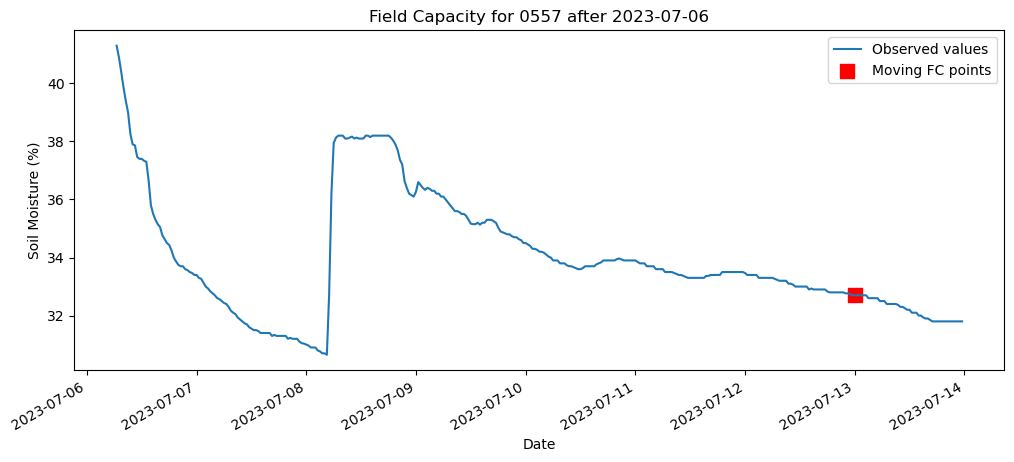

Graph is saved.
Field Capacity is found for 2023-7-28 : 2023-07-30 33.087
                    Station  Layer1  Layer2  Layer3  Layer4  rl_Layer2
2023-07-28 06:30:00     557    23.2    20.7    30.3    32.4  20.700000
2023-07-28 07:00:00     557    31.6    25.2    33.2    34.4  22.200000
2023-07-28 07:30:00     557    38.2    34.7    45.2    39.9  26.866667
2023-07-28 08:00:00     557    34.0    30.6    43.5    40.2  30.166667
2023-07-28 08:30:00     557    38.8    41.3    44.3    40.9  35.533333
...                     ...     ...     ...     ...     ...        ...
2023-07-30 21:30:00     557     NaN    30.7     NaN     NaN  30.700000
2023-07-30 22:00:00     557    29.7    30.7    35.4    35.3  30.700000
2023-07-30 22:30:00     557    29.6    30.7    35.5    35.3  30.700000
2023-07-30 23:00:00     557    29.6    30.7    35.5    35.3  30.700000
2023-07-30 23:30:00     557    29.6    30.7    35.5    35.3  30.700000

[131 rows x 6 columns]


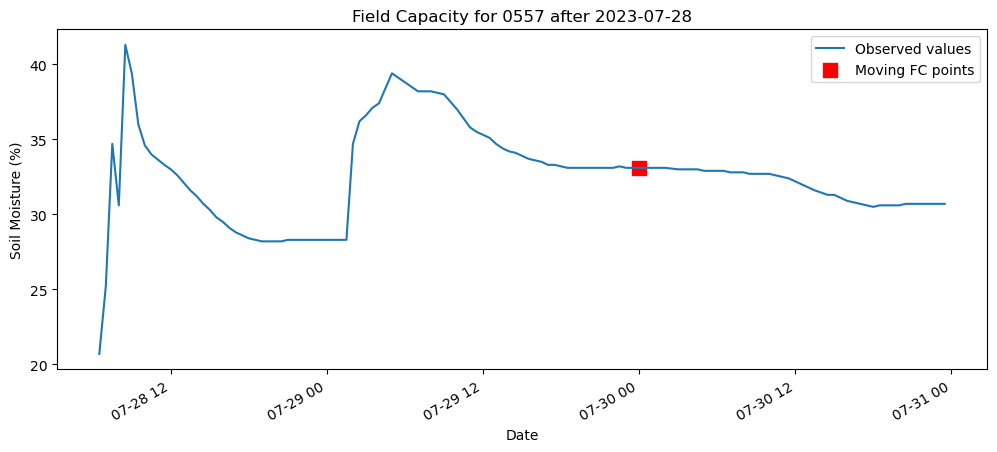

Graph is saved.
Field Capacity is found for 2023-8-5 : 2023-08-08 38.217
                    Station  Layer1  Layer2  Layer3  Layer4  rl_Layer2
2023-08-05 06:30:00     557    24.1    20.8    29.0    32.2  20.816667
2023-08-05 07:00:00     557    24.1    20.9    29.1    32.2  20.833333
2023-08-05 07:30:00     557    24.1    20.8    29.1    32.2  20.833333
2023-08-05 08:00:00     557    24.1    20.8    29.1    32.2  20.833333
2023-08-05 08:30:00     557    24.1    20.8    29.1    32.2  20.800000
...                     ...     ...     ...     ...     ...        ...
2023-08-08 21:30:00     557     NaN    39.6     NaN     NaN  39.600000
2023-08-08 22:00:00     557     NaN    39.6     NaN     NaN  39.600000
2023-08-08 22:30:00     557    39.7    39.6    42.6    43.4  39.600000
2023-08-08 23:00:00     557    39.7    39.6    42.6    43.4  39.600000
2023-08-08 23:30:00     557    39.7    39.5    42.6    43.4  39.566667

[179 rows x 6 columns]


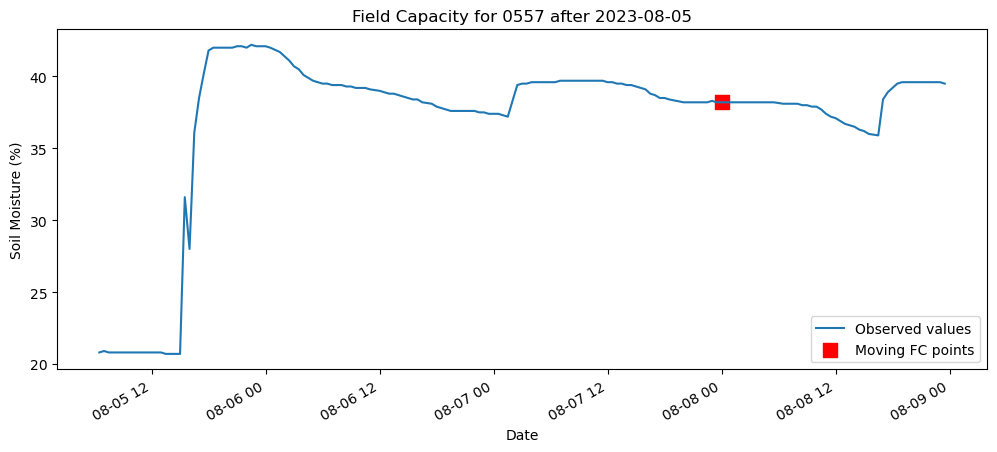

Graph is saved.



=======================0558 :: Layer2=======================
:::::::::::::::::0558 :: Layer2  Rainfinder:::::::::::::::::
0558 | LEN = 2418
Searched  0 days with bump events
[]



=======================0629 :: Layer2=======================
:::::::::::::::::0629 :: Layer2  Rainfinder:::::::::::::::::
0629 | LEN = 363
Searched  0 days with bump events
[]



=======================0630 :: Layer2=======================
:::::::::::::::::0630 :: Layer2  Rainfinder:::::::::::::::::
0630 | LEN = 481
Searched  0 days with bump events
[]



=======================2492 :: Layer2=======================
:::::::::::::::::2492 :: Layer2  Rainfinder:::::::::::::::::
2492 | LEN = 1776
Searched  0 days with bump events
[]


In [206]:
import warnings
warnings.filterwarnings('ignore')

'''
Implementation Block

set up the variables for running the programs
you will set the destination of the files (directory)
you will set the date of your interest.
usually, it is set to today's date

'''

destination = ''
filename = destination + 'Calc_def_test.csv'
foutname = 'FC_data'+strtoday+'.csv'

# set the time of interest and location [year, month, day]

# for regular 
# ed_date = [dt.date.today().year, dt.date.today().month, dt.date.today().day]
# end date will be 
# st_datetime = dt.datetime(ed_date[0], ed_date[1], ed_date[2], 6, 0, 0)
# st_date = [st_datetime.year, st_datetime.month, st_datetime.day]

raw_data, raw_columns, clean_df, stationlist, raw_columns = readraw_data(destination, filename, foutname, st_date, ed_date)


''' 
This part should be done per station [stationlist]
'''
# stationlist = ['0111','0112','0114']
print ('Station List ::',stationlist)

# this is the target layer for the analysis. 1=layer 1
# variable set for rainfinder
target = 'Layer2'
threshold_moist = 15    # threshold of soil moisture difference to decide it was huge rain event or not
raintimestep = 12 # 1 = 1/2 hour

# variable set for FCfinder
search_days = 14 # days
search_range = 5 # hours
search_slope = 0.07 # unit is fraction for standard deviation of the soil moisture behavior
threshold_hour = 4 # hours with consistent soil moisture behavior
# prcp_decision_value = 0.2 # if soilmoisture increase more than this during timestep, it will be considered that it rained


for station in stationlist:
    print('\n\n')
    # TODO: remove stationlist for the final version
    text = station +' :: '+target
    print (text.center(60,'='))
    bumplist = rainfinder(clean_df, station, raw_columns, threshold_moist, raintimestep)
    for start_date in bumplist:
        FCfinder(clean_df, station, raw_columns, start_date, search_days, search_range, search_slope, threshold_hour)




# data_dur_all = FCfinder(clean_df, stationlist, raw_columns, search_range, search_slope, threshold_hour)